# **RNNs in PyTorch**

Here we use the built-in dataset provided by seaborn package. We will first build a network based on LSTM, and then show how to switch to RNN and GRU.

ref: [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


   year     month  passengers
0  1949   January         112
1  1949  February         118
2  1949     March         132
3  1949     April         129
4  1949       May         121
     year      month  passengers
139  1960     August         606
140  1960  September         508
141  1960    October         461
142  1960   November         390
143  1960   December         432
(144, 3)


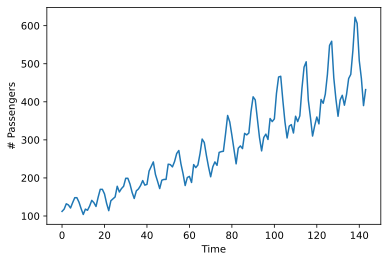

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim
import time
import torch.utils.data
import seaborn as sns
# display routines
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Loading datset
flight_data = sns.load_dataset("flights")
print("{}\n{}".format(flight_data.head(), flight_data.tail()))
print(flight_data.shape)
plt.ylabel('# Passengers')
plt.xlabel('Time')
plt.plot(flight_data['passengers'])
flight_data = flight_data['passengers'].values.astype(float)

PreProcessing

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
flight_data_normalized = scaler.fit_transform(flight_data .reshape(-1, 1))

train_size = 120
train_window = 12 
batch_size = 1
dataset_size = len(flight_data_normalized)
flight_data_normalized = flight_data_normalized.reshape(-1)
flight_data_normalized = flight_data_normalized.astype(np.float32)
# Create input_ouput sequential datast
features = np.zeros((dataset_size-train_window, train_window)).astype(np.float32)
for i in range(train_window):
    # input sequence @(120, 12)
    features[:,i] = flight_data_normalized[i:dataset_size-train_window+i]
# output sequence
labels = flight_data_normalized[train_window:]
train_data = torch.utils.data.TensorDataset(torch.tensor(features[:train_size,:]),
                                            torch.tensor(labels[:train_size])
                                            )
test_data  = torch.utils.data.TensorDataset(torch.tensor(features[train_size:,:]), 
                                            torch.tensor(labels[train_size:])
                                            )

for x, y in train_data:
  print(x, y)
  break

tensor([-0.9691, -0.9459, -0.8919, -0.9035, -0.9344, -0.8803, -0.8301, -0.8301,
        -0.8764, -0.9421, -1.0000, -0.9459]) tensor(-0.9575)


## LSTM model

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=100, output_size=1,
                 batch_size = 16):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # lstm_out: output of shape (seq_len, batch, num_directions * hidden_size)
        # (16*12*100)
        lstm_out, _ = self.lstm(input_seq.view(self.batch_size, 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

test_data_iter = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True)
def calc_test_error(test_data_iter, batch_size = 4):
    test_l = 0
    iters = 0
    test_error = []
    test_pred = []
    for X, y in test_data_iter:
        if not X.shape[0] == batch_size:
            continue
        test_l += loss(net(X), y.reshape(-1,1)).mean().item()
        iters += 1
        test_pred.append(net(X).item())
    test_error.append(test_l/iters)
    return np.mean(test_error), test_pred


net = LSTM(batch_size = batch_size)
loss = nn.MSELoss()
print(net)


epochs = 150
def train_net(net, train_data, loss, epochs, lr):
    train_error = []
    test_error = []
    train_pred = []
    test_pred = []
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        data_iter = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
        net.train()
        for seq, labels in data_iter:
            optimizer.zero_grad()
            if not seq.shape[0] == batch_size:
                continue
            y_pred = net(seq)
            if epoch == epochs -1:
                train_pred.append(y_pred.item())
            l = loss(y_pred, labels)
            l.backward()
            optimizer.step()

        net.eval()
        train_l = 0
        iters = 0
        # train error
        for X, y in data_iter:
            if not X.shape[0] == batch_size:
                continue
            train_l += loss(net(X), y).mean().item()
            iters += 1
        train_error.append(train_l/iters)
        # test error
        t_error, t_pred = calc_test_error(test_data_iter, batch_size)
        test_error.append(t_error)
        if epoch == epochs -1:
            test_pred = t_pred
        if epoch%25 ==0:
            print('epoch {}, train loss: {}, test loss: {}.'.format(epoch, train_error[-1], test_error[-1]))
    return train_error, test_error, train_pred, test_pred

train_error, test_error, train_pred, test_pred = train_net(net, train_data, loss, epochs, 0.01)


LSTM(
  (lstm): LSTM(12, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, train loss: 0.01965958356642356, test loss: 0.038513781226356514.
epoch 25, train loss: 0.005519687193510473, test loss: 0.02031241752411006.
epoch 50, train loss: 0.0015950403295894291, test loss: 0.006222696568632576.
epoch 75, train loss: 0.0014379790070942514, test loss: 0.005311711414227223.
epoch 100, train loss: 0.0017129598668702783, test loss: 0.004287123675264108.
epoch 125, train loss: 0.0017318211940118289, test loss: 0.008402164566102025.


## **Training/test error vs epochs**

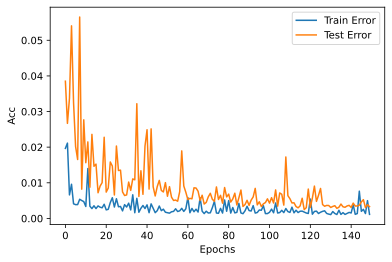

In [4]:
plt.ylabel('Acc')
plt.xlabel('Epochs')
plt.plot(train_error, label="Train Error")
plt.plot(test_error, label="Test Error")
plt.legend()

## **Compare Predictions on testset to Grond truth**

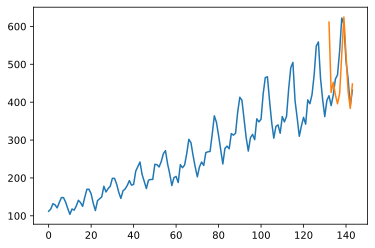

In [5]:
plt.plot(flight_data)
actual_test_predictions = scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
plt.plot(np.arange(132, 144, 1), actual_test_predictions)

# **RNN model**

To use RNN, simply replace LSTM modeule with RNN module

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=100, output_size=1,
                 batch_size = 16):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.batch_size = batch_size

        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        out, _ = self.rnn(input_seq.view(self.batch_size, 1, -1))
        predictions = self.linear(out.view(len(input_seq), -1))
        return predictions[-1]

net = RNN(batch_size = batch_size)
loss = nn.MSELoss()
print(net)


epochs = 150

train_error, test_error, train_pred, test_pred = train_net(net, train_data, loss, epochs, 0.01)


RNN(
  (rnn): RNN(12, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
epoch 0, train loss: 0.01070738086344439, test loss: 0.01844830290307679.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 25, train loss: 0.004517022642180279, test loss: 0.02763549615337979.
epoch 50, train loss: 0.005594530448862164, test loss: 0.010049216958122997.
epoch 75, train loss: 0.006542826407108275, test loss: 0.009049105259085385.
epoch 100, train loss: 0.007686372941218759, test loss: 0.0321715277483842.
epoch 125, train loss: 0.0036262455836795957, test loss: 0.021560747575373778.


# **GRU model**

Same thing applies to GRU

In [8]:
class GRU(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=100, output_size=1,
                 batch_size = 16):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.batch_size = batch_size

        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        out, _ = self.gru(input_seq.view(self.batch_size, 1, -1))
        predictions = self.linear(out.view(len(input_seq), -1))
        return predictions[-1]

net = GRU(batch_size = batch_size)
loss = nn.MSELoss()
print(net)


epochs = 150

train_error, test_error, train_pred, test_pred = train_net(net, train_data, loss, epochs, 0.01)


GRU(
  (gru): GRU(12, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, train loss: 0.014971761531834696, test loss: 0.030417387080281817.
epoch 25, train loss: 0.011047270269346161, test loss: 0.03834354658223068.
epoch 50, train loss: 0.007576928485785809, test loss: 0.022983866821353633.
epoch 75, train loss: 0.0015352783516757876, test loss: 0.018568688719824422.
epoch 100, train loss: 0.001667768721605493, test loss: 0.011211881268536672.
epoch 125, train loss: 0.0015632373684084655, test loss: 0.012301065259331759.
